Confusion Matrix and Statistics

          Reference
Prediction 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26
        1  1 0 0 0 0 0 0 0 0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0
        2  0 2 0 0 0 0 0 0 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
        3  0 0 2 0 0 0 0 0 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
        4  0 0 0 2 0 0 0 0 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
        5  0 0 0 0 2 0 0 0 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
        6  0 0 0 0 0 2 0 0 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
        7  0 0 0 0 0 0 2 0 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
        8  0 0 0 0 0 0 0 2 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
        9  0 0 0 0 0 0 0 0 2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
        10 0 0 0 0 0 0 0 0 0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
        11 0 0 0 0 0 0 0 0 0  0  2  0  0  0  0  0  0  0  0  0  0  0

📂 La base ORL est déjà présente.
Chargement des images...
✅ Dossier de visages trouvé à: orl_faces/orl_faces
Nombre de dossiers sujets trouvés: 40
Traitement du sujet s1: 10 images
Traitement du sujet s10: 10 images
Traitement du sujet s11: 10 images
Traitement du sujet s12: 10 images
Traitement du sujet s13: 10 images
Traitement du sujet s14: 10 images
Traitement du sujet s15: 10 images
Traitement du sujet s16: 10 images
Traitement du sujet s17: 10 images
Traitement du sujet s18: 10 images
Traitement du sujet s19: 10 images
Traitement du sujet s2: 10 images
Traitement du sujet s20: 10 images
Traitement du sujet s21: 10 images
Traitement du sujet s22: 10 images
Traitement du sujet s23: 10 images
Traitement du sujet s24: 10 images
Traitement du sujet s25: 10 images
Traitement du sujet s26: 10 images
Traitement du sujet s27: 10 images
Traitement du sujet s28: 10 images
Traitement du sujet s29: 10 images
Traitement du sujet s3: 10 images
Traitement du sujet s30: 10 images
Traitement du su

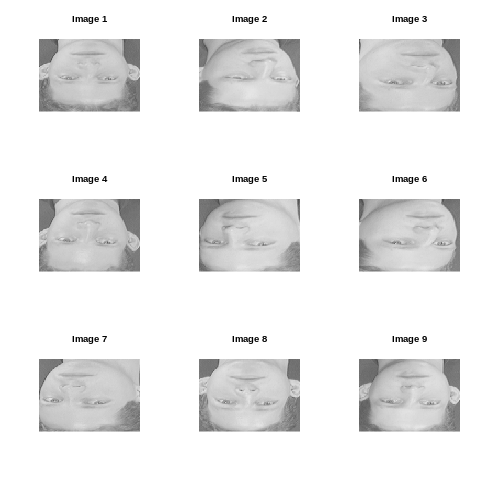

In [91]:
%%R


# Charger les bibliothèques nécessaires
if (!require("EBImage")) {
  if (!requireNamespace("BiocManager", quietly = TRUE)) {
    install.packages("BiocManager")
  }
  BiocManager::install("EBImage")
}
library(EBImage)
library(class)
library(caret)

# Fonction pour lire manuellement un fichier PGM (format P5)
read_pgm_manual <- function(filename) {
  # Ouvrir le fichier en mode binaire
  con <- file(filename, "rb")
  on.exit(close(con))

  # Lire l'en-tête
  format <- readLines(con, n = 1)

  # Ignorer les commentaires
  line <- readLines(con, n = 1)
  while (substr(line, 1, 1) == "#") {
    line <- readLines(con, n = 1)
  }

  # Lire les dimensions
  dimensions <- as.integer(strsplit(line, " ")[[1]])
  width <- dimensions[1]
  height <- dimensions[2]

  # Lire la valeur max
  max_val <- as.integer(readLines(con, n = 1))

  # Lire les données d'image
  image_data <- readBin(con, what = "raw", n = width * height)

  # Convertir en matrice d'entiers puis en numeric
  image_matrix <- matrix(as.numeric(as.integer(image_data)),
                         nrow = height, ncol = width, byrow = TRUE)

  # Normaliser entre 0 et 1
  image_matrix <- image_matrix / max_val

  return(image_matrix)
}

# Télécharger et extraire la base ORL
download_and_extract_orl_faces <- function() {
  url <- "http://www.cl.cam.ac.uk/Research/DTG/attarchive/pub/data/att_faces.tar.Z"
  archive_name <- "att_faces.tar.Z"
  tar_name <- "att_faces.tar"
  extracted_folder <- "orl_faces"

  if (!file.exists(extracted_folder)) {
    message("🔽 Téléchargement de la base ORL...")
    download.file(url, archive_name, mode = "wb")
    message("✅ Téléchargement terminé.")
    system(paste("uncompress", archive_name))
    message("📦 Extraction du .tar...")
    untar(tar_name, exdir = extracted_folder)
    message("✅ Base ORL prête à l'emploi dans 'orl_faces' !")
  } else {
    message("📂 La base ORL est déjà présente.")
  }
}

# Charger les visages ORL
load_orl_faces <- function() {
  # Vérifier si le dossier existe
  if (!dir.exists("orl_faces")) {
    stop("Le dossier 'orl_faces' n'existe pas. Exécutez d'abord download_and_extract_orl_faces().")
  }

  # Déterminer le chemin correct
  potential_paths <- c(
    "orl_faces/att_faces",
    "orl_faces/orl_faces",
    "orl_faces"
  )

  folder <- NULL
  for (path in potential_paths) {
    if (dir.exists(path)) {
      folders <- list.dirs(path, full.names = FALSE, recursive = FALSE)
      if (any(grepl("^s[0-9]+$", folders))) {
        folder <- path
        message(paste("✅ Dossier de visages trouvé à:", folder))
        break
      }
    }
  }

  if (is.null(folder)) {
    stop("Impossible de trouver le dossier contenant les visages.")
  }

  # Obtenir tous les sous-dossiers sujets (s1, s2, etc.)
  subject_folders <- list.dirs(folder, recursive = FALSE)
  subject_folders <- subject_folders[grepl("/s[0-9]+$", subject_folders)]

  message(paste("Nombre de dossiers sujets trouvés:", length(subject_folders)))

  all_images <- list()
  all_labels <- c()
  images_read <- 0

  for (subject_folder in subject_folders) {
    subject_id <- as.numeric(gsub(".*s([0-9]+)$", "\\1", subject_folder))
    files <- list.files(subject_folder, pattern = "\\.pgm$", full.names = TRUE)

    message(paste("Traitement du sujet s", subject_id, ": ", length(files), " images", sep=""))

    if (length(files) == 0) {
      warning(paste("Aucun fichier PGM trouvé dans", subject_folder))
      next
    }

    for (file_path in files) {
      # Essayer deux méthodes de lecture
      success <- FALSE

      # Méthode 1: Utiliser readImage de EBImage
      tryCatch({
        img <- readImage(file_path)
        if (!is.null(img)) {
          # Convertir en niveaux de gris si nécessaire
          if (length(dim(img)) > 2) {
            img <- channel(img, "gray")
          }
          img_vector <- as.vector(img)
          all_images[[length(all_images) + 1]] <- img_vector
          all_labels <- c(all_labels, subject_id)
          images_read <- images_read + 1
          success <- TRUE
        }
      }, error = function(e) {
        # Si la méthode 1 échoue, on passe à la méthode 2
      })

      # Méthode 2: Utiliser notre fonction personnalisée
      if (!success) {
        tryCatch({
          img <- read_pgm_manual(file_path)
          if (!is.null(img)) {
            img_vector <- as.vector(img)
            all_images[[length(all_images) + 1]] <- img_vector
            all_labels <- c(all_labels, subject_id)
            images_read <- images_read + 1
            success <- TRUE
          }
        }, error = function(e) {
          warning(paste("Impossible de lire l'image", file_path, ":", e$message))
        })
      }
    }
  }

  if (images_read == 0) {
    stop("Aucune image lue. Vérifiez les fichiers et le format.")
  }

  message(paste("Total:", images_read, "images lues avec succès."))

  # Vérifier que toutes les images ont la même dimension
  dimensions <- sapply(all_images, length)
  if (length(unique(dimensions)) > 1) {
    warning("Les images n'ont pas toutes la même taille. Tentative d'adaptation...")
    # Utiliser la dimension la plus fréquente
    most_common_dim <- as.numeric(names(sort(table(dimensions), decreasing = TRUE)[1]))
    all_images <- all_images[dimensions == most_common_dim]
    all_labels <- all_labels[dimensions == most_common_dim]
    message(paste("Après adaptation:", length(all_images), "images conservées"))
  }

  # Créer la matrice X et le vecteur y
  X <- do.call(rbind, all_images)
  y <- factor(all_labels)

  message(paste("Dimensions finales: X =", nrow(X), "×", ncol(X), ", y =", length(y)))

  return(list(X = X, y = y))
}

# Afficher quelques images
afficher_images <- function(X, rows = 112, cols = 92) {
  par(mfrow = c(3, 3))
  for (i in 1:min(9, nrow(X))) {
    img_matrix <- matrix(X[i, ], nrow = rows, ncol = cols)
    image(t(img_matrix), col = gray.colors(256), axes = FALSE, main = paste("Image", i))
  }
}

# Programme principal
main <- function() {
  # Télécharger si nécessaire
  download_and_extract_orl_faces()

  # Charger les données
  tryCatch({
    message("Chargement des images...")
    data <- load_orl_faces()

    if (is.null(data) || nrow(data$X) == 0) {
      stop("Échec du chargement des données.")
    }

    X <- data$X
    y <- data$y

    message("Affichage de quelques images...")
    afficher_images(X)

    # Diviser les données
    set.seed(42)
    split_index <- createDataPartition(y, p = 0.75, list = FALSE)
    X_train <- X[split_index, ]
    X_test <- X[-split_index, ]
    y_train <- y[split_index]
    y_test <- y[-split_index]

    # PCA
    message("Calcul de la PCA...")
    # Centrer et normaliser les données
    X_centered <- scale(X_train, center = TRUE, scale = TRUE)
    pca <- prcomp(X_centered)

    # Déterminer le nombre de composantes à conserver (ex: 95% de la variance)
    var_explained <- cumsum(pca$sdev^2 / sum(pca$sdev^2))
    n_components <- which(var_explained >= 0.95)[1]
    if (is.na(n_components) || n_components > 100) {
      n_components <- min(100, length(pca$sdev))
    }
    message(paste("Utilisation de", n_components, "composantes PCA"))

    # Appliquer la PCA
    X_train_pca <- predict(pca, X_train)[, 1:n_components]
    X_test_pca <- predict(pca, X_test)[, 1:n_components]

    # KNN avec PCA
    message("Classification KNN...")
    k_value <- 3  # ou autre valeur à déterminer
    knn_pca <- knn(X_train_pca, X_test_pca, y_train, k = k_value)

    # Évaluation
    confusion <- confusionMatrix(knn_pca, y_test)
    print(confusion)
    message(paste("Précision globale:", round(confusion$overall[1] * 100, 2), "%"))

  }, error = function(e) {
    message(paste("Erreur dans le programme principal:", e$message))
  })
}

# Lancer le programme
main()


In [88]:
Warning()

Warning()

In [ ]:
%%R
# Vérification des fichiers .pgm dans le dossier
subfolders <- list.dirs("orl_faces/orl_faces", recursive = TRUE)
print(subfolders)




 [1] "orl_faces/orl_faces"     "orl_faces/orl_faces/s1" 
 [3] "orl_faces/orl_faces/s10" "orl_faces/orl_faces/s11"
 [5] "orl_faces/orl_faces/s12" "orl_faces/orl_faces/s13"
 [7] "orl_faces/orl_faces/s14" "orl_faces/orl_faces/s15"
 [9] "orl_faces/orl_faces/s16" "orl_faces/orl_faces/s17"
[11] "orl_faces/orl_faces/s18" "orl_faces/orl_faces/s19"
[13] "orl_faces/orl_faces/s2"  "orl_faces/orl_faces/s20"
[15] "orl_faces/orl_faces/s21" "orl_faces/orl_faces/s22"
[17] "orl_faces/orl_faces/s23" "orl_faces/orl_faces/s24"
[19] "orl_faces/orl_faces/s25" "orl_faces/orl_faces/s26"
[21] "orl_faces/orl_faces/s27" "orl_faces/orl_faces/s28"
[23] "orl_faces/orl_faces/s29" "orl_faces/orl_faces/s3" 
[25] "orl_faces/orl_faces/s30" "orl_faces/orl_faces/s31"
[27] "orl_faces/orl_faces/s32" "orl_faces/orl_faces/s33"
[29] "orl_faces/orl_faces/s34" "orl_faces/orl_faces/s35"
[31] "orl_faces/orl_faces/s36" "orl_faces/orl_faces/s37"
[33] "orl_faces/orl_faces/s38" "orl_faces/orl_faces/s39"
[35] "orl_faces/orl_faces/s4"  

In [ ]:
%%R
list.dirs("orl_faces", recursive = TRUE)


 [1] "orl_faces"               "orl_faces/orl_faces"    
 [3] "orl_faces/orl_faces/s1"  "orl_faces/orl_faces/s10"
 [5] "orl_faces/orl_faces/s11" "orl_faces/orl_faces/s12"
 [7] "orl_faces/orl_faces/s13" "orl_faces/orl_faces/s14"
 [9] "orl_faces/orl_faces/s15" "orl_faces/orl_faces/s16"
[11] "orl_faces/orl_faces/s17" "orl_faces/orl_faces/s18"
[13] "orl_faces/orl_faces/s19" "orl_faces/orl_faces/s2" 
[15] "orl_faces/orl_faces/s20" "orl_faces/orl_faces/s21"
[17] "orl_faces/orl_faces/s22" "orl_faces/orl_faces/s23"
[19] "orl_faces/orl_faces/s24" "orl_faces/orl_faces/s25"
[21] "orl_faces/orl_faces/s26" "orl_faces/orl_faces/s27"
[23] "orl_faces/orl_faces/s28" "orl_faces/orl_faces/s29"
[25] "orl_faces/orl_faces/s3"  "orl_faces/orl_faces/s30"
[27] "orl_faces/orl_faces/s31" "orl_faces/orl_faces/s32"
[29] "orl_faces/orl_faces/s33" "orl_faces/orl_faces/s34"
[31] "orl_faces/orl_faces/s35" "orl_faces/orl_faces/s36"
[33] "orl_faces/orl_faces/s37" "orl_faces/orl_faces/s38"
[35] "orl_faces/orl_faces/s39" 

In [ ]:
%%R
install.packages("BiocManager")
BiocManager::install("EBImage")


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)
trying URL 'https://cran.rstudio.com/src/contrib/BiocManager_1.30.25.tar.gz'
Content type 'application/x-gzip' length 593414 bytes (579 KB)
downloaded 579 KB


The downloaded source packages are in
	‘/tmp/RtmpTDbVmR/downloaded_packages’
'getOption("repos")' replaces Bioconductor standard repositories, see
'help("repositories", package = "BiocManager")' for details.
Replacement repositories:
    CRAN: https://cran.rstudio.com
Bioconductor version 3.20 (BiocManager 1.30.25), R 4.4.3 (2025-02-28)
In addition: Warning message:
package(s) not installed when version(s) same as or greater than current; use
  `force = TRUE` to re-install: 'EBImage' 


In [ ]:
%%R
library(EBImage)

# Lire l'image PGM
image <- readImage("chemin/vers/ton_image.pgm")

# Sauvegarder l'image en PNG
writeImage(image, "chemin/vers/ton_image_convertie.png")

cat("L'image a été convertie avec succès !")


Error in readImage("chemin/vers/ton_image.pgm") : 
  Invalid type: pgm. Currently supported formats are JPEG, PNG, and TIFF.


RInterpreterError: Failed to parse and evaluate line 'library(EBImage)\n\n# Lire l\'image PGM\nimage <- readImage("chemin/vers/ton_image.pgm")\n\n# Sauvegarder l\'image en PNG\nwriteImage(image, "chemin/vers/ton_image_convertie.png")\n\ncat("L\'image a été convertie avec succès !")\n'.
R error message: 'Error in readImage("chemin/vers/ton_image.pgm") : \n  Invalid type: pgm. Currently supported formats are JPEG, PNG, and TIFF.'

In [ ]:
%%R
install.packages("pixmap")


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)
trying URL 'https://cran.rstudio.com/src/contrib/pixmap_0.4-13.tar.gz'
Content type 'application/x-gzip' length 34980 bytes (34 KB)
downloaded 34 KB


The downloaded source packages are in
	‘/tmp/RtmpTDbVmR/downloaded_packages’


In [ ]:
%%R
# Charger la bibliothèque nécessaire
library(pixmap)

# Spécifier le chemin de l'image PGM (modifie ceci selon ton chemin)
chemin_image <- "chemin/vers/ton_image.pgm"  # Remplace par le chemin réel de ton fichier PGM

# Vérifier si l'image existe à l'emplacement spécifié
if (file.exists(chemin_image)) {
  # Lire l'image PGM
  image <- read.pnm(chemin_image)

  # Spécifier le chemin où l'image PNG sera sauvegardée
  chemin_sauvegarde <- "chemin/vers/ton_image_convertie.png"  # Remplace par le chemin où tu veux sauvegarder l'image

  # Sauvegarder l'image en format PNG
  png(chemin_sauvegarde)
  plot(image)
  dev.off()

  # Message de succès
  cat("L'image a été convertie avec succès en PNG !\n")
} else {
  # Message si l'image n'est pas trouvée
  cat("Erreur : L'image spécifiée n'existe pas.\n")
}



Erreur : L'image spécifiée n'existe pas.


In [ ]:
%%R
# Spécifier le chemin absolu de l'image PGM (remplace par ton chemin réel)
chemin_image <- "C:/Users/TonNom/Documents/ton_image.pgm"  # Windows
# ou pour Linux/Mac :
# chemin_image <- "/home/ton_utilisateur/Documents/ton_image.pgm"


In [ ]:
%%R
unlink("orl_faces", recursive = TRUE)  # Supprimer le dossier orl_faces si présent
download_and_extract_orl_faces()  # Relancer l'extraction









🔽 Téléchargement de la base ORL...
trying URL 'http://www.cl.cam.ac.uk/Research/DTG/attarchive/pub/data/att_faces.tar.Z'
Content type 'application/x-compress' length 4075767 bytes (3.9 MB)
downloaded 3.9 MB

✅ Téléchargement terminé.
📦 Extraction du .tar...
✅ Base ORL prête à l'emploi dans 'orl_faces' !


In [ ]:
%%R
# Vérifier le contenu du dossier 'orl_faces'
# Vérifier les fichiers .pgm dans les sous-dossiers 's1', 's2', etc.
list.files("orl_faces/orl_faces", pattern = "\\.pgm$", full.names = TRUE, recursive = TRUE)




  [1] "orl_faces/orl_faces/s1/1.pgm"   "orl_faces/orl_faces/s1/10.pgm" 
  [3] "orl_faces/orl_faces/s1/2.pgm"   "orl_faces/orl_faces/s1/3.pgm"  
  [5] "orl_faces/orl_faces/s1/4.pgm"   "orl_faces/orl_faces/s1/5.pgm"  
  [7] "orl_faces/orl_faces/s1/6.pgm"   "orl_faces/orl_faces/s1/7.pgm"  
  [9] "orl_faces/orl_faces/s1/8.pgm"   "orl_faces/orl_faces/s1/9.pgm"  
 [11] "orl_faces/orl_faces/s10/1.pgm"  "orl_faces/orl_faces/s10/10.pgm"
 [13] "orl_faces/orl_faces/s10/2.pgm"  "orl_faces/orl_faces/s10/3.pgm" 
 [15] "orl_faces/orl_faces/s10/4.pgm"  "orl_faces/orl_faces/s10/5.pgm" 
 [17] "orl_faces/orl_faces/s10/6.pgm"  "orl_faces/orl_faces/s10/7.pgm" 
 [19] "orl_faces/orl_faces/s10/8.pgm"  "orl_faces/orl_faces/s10/9.pgm" 
 [21] "orl_faces/orl_faces/s11/1.pgm"  "orl_faces/orl_faces/s11/10.pgm"
 [23] "orl_faces/orl_faces/s11/2.pgm"  "orl_faces/orl_faces/s11/3.pgm" 
 [25] "orl_faces/orl_faces/s11/4.pgm"  "orl_faces/orl_faces/s11/5.pgm" 
 [27] "orl_faces/orl_faces/s11/6.pgm"  "orl_faces/orl_faces/s11/

In [ ]:
%%R
list.files("orl_faces/att_faces", full.names = TRUE)





character(0)


In [ ]:
!tar -xvf att_faces.tar


orl_faces/
orl_faces/README
orl_faces/s1/
orl_faces/s1/6.pgm
orl_faces/s1/7.pgm
orl_faces/s1/8.pgm
orl_faces/s1/9.pgm
orl_faces/s1/10.pgm
orl_faces/s1/1.pgm
orl_faces/s1/2.pgm
orl_faces/s1/3.pgm
orl_faces/s1/4.pgm
orl_faces/s1/5.pgm
orl_faces/s2/
orl_faces/s2/6.pgm
orl_faces/s2/7.pgm
orl_faces/s2/8.pgm
orl_faces/s2/9.pgm
orl_faces/s2/10.pgm
orl_faces/s2/1.pgm
orl_faces/s2/2.pgm
orl_faces/s2/3.pgm
orl_faces/s2/4.pgm
orl_faces/s2/5.pgm
orl_faces/s3/
orl_faces/s3/6.pgm
orl_faces/s3/7.pgm
orl_faces/s3/8.pgm
orl_faces/s3/9.pgm
orl_faces/s3/10.pgm
orl_faces/s3/1.pgm
orl_faces/s3/2.pgm
orl_faces/s3/3.pgm
orl_faces/s3/4.pgm
orl_faces/s3/5.pgm
orl_faces/s4/
orl_faces/s4/6.pgm
orl_faces/s4/7.pgm
orl_faces/s4/8.pgm
orl_faces/s4/9.pgm
orl_faces/s4/10.pgm
orl_faces/s4/1.pgm
orl_faces/s4/2.pgm
orl_faces/s4/3.pgm
orl_faces/s4/4.pgm
orl_faces/s4/5.pgm
orl_faces/s5/
orl_faces/s5/6.pgm
orl_faces/s5/7.pgm
orl_faces/s5/8.pgm
orl_faces/s5/9.pgm
orl_faces/s5/10.pgm
orl_faces/s5/1.pgm
orl_faces/s5/2.pgm
orl_

In [ ]:
%%R
install.packages("fftwtools")
if (!requireNamespace("BiocManager", quietly = TRUE))
    install.packages("BiocManager")
BiocManager::install("EBImage")


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)
trying URL 'https://cran.rstudio.com/src/contrib/fftwtools_0.9-11.tar.gz'
Content type 'application/x-gzip' length 174321 bytes (170 KB)
downloaded 170 KB


The downloaded source packages are in
	‘/tmp/RtmpTDbVmR/downloaded_packages’
'getOption("repos")' replaces Bioconductor standard repositories, see
'help("repositories", package = "BiocManager")' for details.
Replacement repositories:
    CRAN: https://cran.rstudio.com
Bioconductor version 3.20 (BiocManager 1.30.25), R 4.4.3 (2025-02-28)
Installing package(s) 'EBImage'
trying URL 'https://bioconductor.org/packages/3.20/bioc/src/contrib/EBImage_4.48.0.tar.gz'
Content type 'application/x-gzip' length 5466628 bytes (5.2 MB)
downloaded 5.2 MB


The downloaded source packages are in
	‘/tmp/RtmpTDbVmR/downloaded_packages’


In [ ]:
%%R
install.packages("BiocManager")






Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)
trying URL 'https://cran.rstudio.com/src/contrib/BiocManager_1.30.25.tar.gz'
Content type 'application/x-gzip' length 593414 bytes (579 KB)
downloaded 579 KB


The downloaded source packages are in
	‘/tmp/RtmpTDbVmR/downloaded_packages’


In [ ]:
%%R
BiocManager::install("EBImage")


'getOption("repos")' replaces Bioconductor standard repositories, see
'help("repositories", package = "BiocManager")' for details.
Replacement repositories:
    CRAN: https://cran.rstudio.com
Bioconductor version 3.20 (BiocManager 1.30.25), R 4.4.3 (2025-02-28)
Installing package(s) 'EBImage'
also installing the dependency ‘fftwtools’

trying URL 'https://cran.rstudio.com/src/contrib/fftwtools_0.9-11.tar.gz'
Content type 'application/x-gzip' length 174321 bytes (170 KB)
downloaded 170 KB

trying URL 'https://bioconductor.org/packages/3.20/bioc/src/contrib/EBImage_4.48.0.tar.gz'
Content type 'application/x-gzip' length 5466628 bytes (5.2 MB)
downloaded 5.2 MB


The downloaded source packages are in
	‘/tmp/RtmpTDbVmR/downloaded_packages’
In addition: Warning messages:
1: In install.packages(...) :
  installation of package ‘fftwtools’ had non-zero exit status
2: In install.packages(...) :
  installation of package ‘EBImage’ had non-zero exit status


In [ ]:
%%R
install.packages("fftwtools")


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)
trying URL 'https://cran.rstudio.com/src/contrib/fftwtools_0.9-11.tar.gz'
Content type 'application/x-gzip' length 174321 bytes (170 KB)
downloaded 170 KB


The downloaded source packages are in
	‘/tmp/RtmpTDbVmR/downloaded_packages’
In addition: Warning message:
In install.packages("fftwtools") :
  installation of package ‘fftwtools’ had non-zero exit status


In [ ]:
!sudo apt-get update
!sudo apt-get install libfftw3-dev libtiff5-dev libjpeg-dev libpng-dev libx11-dev libxt-dev




Hit:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Get:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:3 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:5 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:7 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ Packages [72.6 kB]
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Get:9 https://r2u.stat.illinois.edu/ubuntu jammy/main all Packages [8,824 kB]
Hit:10 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:11 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Hit:12 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Get:13 https://r2u.stat.illinois.edu/ubuntu jammy/main amd64 Packages [2,688 kB]
Get:14

In [ ]:
%%R
install.packages("png")
library(png)


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)
trying URL 'https://cran.rstudio.com/src/contrib/png_0.1-8.tar.gz'
Content type 'application/x-gzip' length 24880 bytes (24 KB)
downloaded 24 KB


The downloaded source packages are in
	‘/tmp/RtmpTDbVmR/downloaded_packages’


In [ ]:
%%R
install.packages("caret")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)
also installing the dependencies ‘listenv’, ‘parallelly’, ‘future’, ‘globals’, ‘shape’, ‘future.apply’, ‘numDeriv’, ‘progressr’, ‘SQUAREM’, ‘diagram’, ‘lava’, ‘prodlim’, ‘proxy’, ‘iterators’, ‘clock’, ‘gower’, ‘hardhat’, ‘ipred’, ‘sparsevctrs’, ‘timeDate’, ‘e1071’, ‘foreach’, ‘ModelMetrics’, ‘plyr’, ‘pROC’, ‘recipes’, ‘reshape2’

trying URL 'https://cran.rstudio.com/src/contrib/listenv_0.9.1.tar.gz'
Content type 'application/x-gzip' length 36600 bytes (35 KB)
downloaded 35 KB

trying URL 'https://cran.rstudio.com/src/contrib/parallelly_1.43.0.tar.gz'
Content type 'application/x-gzip' length 310739 bytes (303 KB)
downloaded 303 KB

trying URL 'https://cran.rstudio.com/src/contrib/future_1.40.0.tar.gz'
Content type 'application/x-gzip' length 415303 bytes (405 KB)
downloaded 405 KB

trying URL 'https://cran.rstudio.com/src/contrib/globals_0.16.3.tar.gz'
Content type 'application/x-gzip' length 37475 bytes (

In [ ]:
%%R
install.packages("rpart")
install.packages("rpart.plot")


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)
trying URL 'https://cran.rstudio.com/src/contrib/rpart_4.1.24.tar.gz'
Content type 'application/x-gzip' length 620065 bytes (605 KB)
downloaded 605 KB


The downloaded source packages are in
	‘/tmp/RtmpTDbVmR/downloaded_packages’
Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)
trying URL 'https://cran.rstudio.com/src/contrib/rpart.plot_3.1.2.tar.gz'
Content type 'application/x-gzip' length 673083 bytes (657 KB)
downloaded 657 KB


The downloaded source packages are in
	‘/tmp/RtmpTDbVmR/downloaded_packages’


In [ ]:
%load_ext rpy2.ipython